In [66]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import pdir as pr
import pandas as pd
import os
from tqdm import tqdm, tnrange, tqdm_notebook

DF = pd.DataFrame
arr = np.array

# 读取数据

In [67]:
dirPath = "data preprocessed\\normalized\\remove-feature-[day]"

means, stds = eval(open(dirPath + "\\means_and_stds_about_trainset.py").read())

trainSet_origin = np.loadtxt(dirPath + '\\train.csv', delimiter=",")
validateSet_origin = np.loadtxt(dirPath + '\\validate.csv', delimiter=",")
testSet = np.loadtxt(dirPath + '\\test.csv', delimiter=",")

trainSet_origin.shape, validateSet_origin.shape, testSet.shape

((13625, 44), (2990, 44), (742, 43))

划分数据集特征和标签：

In [68]:
trainSet, trainSetLabel = trainSet_origin[:, :-1], trainSet_origin[:, -1]
validateSet, validateSetLabel = validateSet_origin[:, :-1], validateSet_origin[:, -1]
trainSet.shape, validateSet.shape

((13625, 43), (2990, 43))

# 归一化预测标签值

In [69]:
trainSetLabel.mean(), trainSetLabel.std() #处理前的均值和方差

(172.48080733944954, 164.98361847646188)

In [70]:
mean_of_cnt, std_of_cnt = trainSetLabel.mean(), trainSetLabel.std()

trainSetLabel = (trainSetLabel - mean_of_cnt)/std_of_cnt
validateSetLabel = (validateSetLabel - mean_of_cnt)/std_of_cnt

In [71]:
pd.concat([DF(trainSetLabel).describe(), DF(validateSetLabel).describe()], axis=1)

,0,0
count,1.362500e+04,2990.000000
mean,1.653422e-15,0.605357
std,1.000037e+00,1.379535
min,-1.039381e+00,-1.039381
25%,-8.272385e-01,-0.619642
50%,-2.635462e-01,0.348636
75%,4.941048e-01,1.415408
max,4.755134e+00,4.876358


# 损失函数实现

这里实现损失函数来衡量算法的准确率。

In [72]:
def calcLoss(predict, label):
    '''计算预测值相对于标签值的损失值，默认使用均方误差'''
    def MeanSquareError(a, b):
        '''计算均方误差'''
        return 1/2*np.mean((a - b)**2)
    
    return MeanSquareError(predict, label)

# 神经网络

In [73]:
class NeuralNetwork(object):
    '''神经网络类实现'''
    def __init__(self, n_input, n_hidden, n_output, learning_rate, SGD_batch_size=-1):
        '''初始化函数'''
        #设置 输入层、隐藏层、输出层结点个数
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        #设置 学习率
        self.lr = learning_rate
        #设置 激活函数
        self.activation_function = lambda x : 1/(1+np.exp(-x))
        #设置随机梯度下降每次抽取的样本个数，-1代表使用 批梯度下降
        self.SGD_batch_size = SGD_batch_size
        
        #初始化 输入层到隐藏层、隐藏层到输出层的权重矩阵为正态分布
        self.weights_input_to_hidden = np.random.normal(0, self.n_input**(-0.5),
                                                        (self.n_input, self.n_hidden))
        self.weights_hidden_to_output = np.random.normal(0, self.n_hidden**(-0.5),
                                                         (self.n_hidden, self.n_output))
    
    def fit(self, features, labels):
        '''根据训练集训练算法'''
        #得到样本总数
        totSampleNum = features.shape[0]
        #初始化 权重步长矩阵
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        #选取用于训练的样本
        sampleDatas, sampleLabels = features.copy(), labels.copy()
        if self.SGD_batch_size != -1:
            #从训练集中随机均匀无重复地抽取一定样本，并按从小到大排序
            sampleIdxes = np.random.choice(totSampleNum, SGD_batch_size, replace=False)
            sampleIdxes.sort()
            #得到采样后的一部分数据
            sampleDatas, sampleLabels = features[sampleIdxes], labels[sampleIdxes]
            
        for X, y in zip(sampleDatas, sampleLabels):
            ### 前向传播过程 ###
            #计算 隐藏层 输入和输出
            hidden_inputs = np.dot(X, self.weights_input_to_hidden)
            hidden_outputs = self.activation_function(hidden_inputs)
        
            #计算 输出层 输入和输出
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
            final_outputs = final_inputs #final_outputs=f(final_inputs)=final_inputs
        
            ### 后向传播过程 ###
            #计算 输出层输出 和 目标标签值 的误差
            error = y - final_outputs
            #计算 输出层 误差梯度
            output_error_term = error # = error*1
            #更新 隐藏层到输出层 的 权重步长矩阵
            delta_weights_h_o += hidden_outputs.reshape(-1,1)*output_error_term
            
            #计算 传播到 隐藏层 的误差
            hidden_error = np.dot(self.weights_hidden_to_output, output_error_term)
            #计算 隐藏层 误差梯度
            hidden_error_term = hidden_error*hidden_outputs*(1-hidden_outputs)
            # 更新 输入层到隐藏层的权重步长矩阵(广播运算，或者外积）
            delta_weights_i_h += X.reshape(-1,1)*hidden_error_term
            

        #更新 权重矩阵
        self.weights_hidden_to_output += self.lr*delta_weights_h_o/totSampleNum
        self.weights_input_to_hidden += self.lr*delta_weights_i_h/totSampleNum
 
    def apply(self, features):
        '''应用训练好的参数到输入数据集上'''
        hidden_inputs = np.dot(features, self.weights_input_to_hidden)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output)
        final_outputs = final_inputs 
        
        return final_outputs
    
features_train = np.array([[0.5, -0.2, 0.1]]) #训练集特征
labels_train = np.array([[0.4]])              #训练集标签
features_test = features_train.copy()         #测试集特征
labels_test = np.array([[0.16666906]])        #测试集标签
#输入层 到 隐藏层 的初始权重矩阵
weights_input_to_hidden_init = np.array([[0.1, -0.2], 
                                         [0.4, 0.5],
                                         [-0.3, 0.2]])
#输入层 到 隐藏层 的最终权重矩阵
weights_input_to_hidden_ans = np.array([[0.10562014, -0.20185996], 
                                        [0.39775194, 0.50074398], 
                                        [-0.29887597, 0.19962801]])
#隐藏层 到 输出层 的初始权重矩阵
weights_hidden_to_output_init = np.array([[0.3], [-0.1]])
#隐藏层 到 输出层 的最终权重矩阵
weights_hidden_to_output_ans = np.array([[0.37275328], [-0.03172939]])

#设置 输入层、隐藏层 、输出层结点个数依次为 3、2、1，学习率为 0.5
NNet_test = NeuralNetwork(3, 2, 1, 0.5)

#覆盖两个 权重矩阵 的初始值
NNet_test.weights_input_to_hidden = weights_input_to_hidden_init.copy()
NNet_test.weights_hidden_to_output = weights_hidden_to_output_init.copy()
#训练算法，迭代一次
NNet_test.fit(features_train, labels_train)

assert(np.allclose(NNet_test.weights_input_to_hidden, weights_input_to_hidden_ans))

assert(np.allclose(NNet_test.weights_hidden_to_output, weights_hidden_to_output_ans))

predict_test = NNet_test.apply(features_test)
assert(np.allclose(predict_test, labels_test))

# 调参

参考[神经网络学习之参数的设置原则][神经网络学习之参数的设置原则]进行调参。需要调参的参数有：学习率、隐藏层个数、随机梯度下降使用的样本的个数。

[神经网络学习之参数的设置原则]:https://www.cnblogs.com/sunfie/p/5519604.html

## 多次迭代运行算法

In [261]:
### 需调参的参数 ###
learning_rate = 0.4
n_hidden = 8
SGD_batch_size = -1
### 不需调参的参数 ###
n_output = 1
n_input = trainSet.shape[1]

network = NeuralNetwork(n_input, n_hidden, n_output, learning_rate, SGD_batch_size)

runTime = 300
testRange = range(1, runTime+1)
trainLosses, validationLosses = np.zeros(runTime), np.zeros(runTime)
for i in tnrange(runTime):
    #使用数据训练算法
    network.fit(trainSet, trainSetLabel)
    #得到算法对 训练集 和 验证集 的预测标签
    trainPredictLabel = network.apply(trainSet).T
    validPredictLabel = network.apply(validateSet).T
    #计算 损失值 并 保存 损失值结果
    trainLosses[i] = calcLoss(trainPredictLabel, trainSetLabel)
    validationLosses[i] = calcLoss(validPredictLabel, validateSetLabel)

## 绘制损失值随迭代此时变化的曲线

In [262]:
InteractiveShell.ast_node_interactivity = "none"

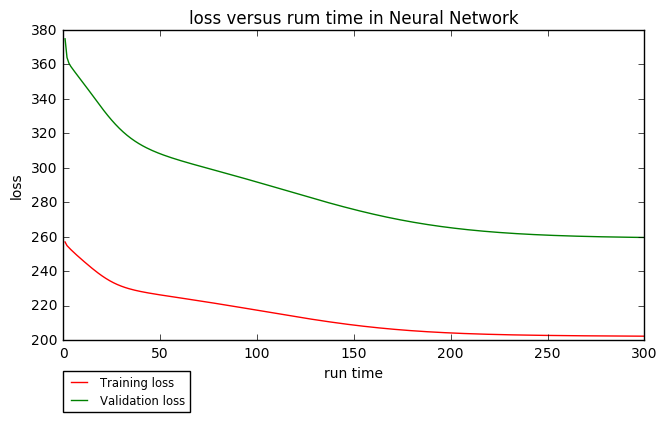

In [263]:
fig, ax = plt.subplots() 
fig.set_size_inches(7.5, 4)
plt.plot(testRange, trainLosses*std_of_cnt+mean_of_cnt, 'r', label="Training loss")
plt.plot(testRange, validationLosses*std_of_cnt+mean_of_cnt, 'g', label="Validation loss")
plt.xlabel('run time')
plt.ylabel('loss')
plt.title("loss versus rum time in Neural Network")
plt.legend(bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0., fontsize='small')
plt.show()
plt.close()

In [264]:
InteractiveShell.ast_node_interactivity = "all"

# 绘制对验证集后21天的预测值与实际值的对比图

由于之前划分验证集时是直接取原有数据集的后18%作为验证集的，这里取验证集的后21天作为测试也相当于取原有数据集的后21天作为测试，保存了数据在时间上的连续性。

In [265]:
num = 21*24 # 数据个数
last21Days_range = np.arange(num) #样本范围
last21Days_features, last21Days_labels = validateSet[-num:], validateSetLabel[-num:]
#使用算法进行预测
last21Days_predicts = network.apply(last21Days_features)
#还原归一化后的数据
last21Days_predicts = last21Days_predicts.flatten()*std_of_cnt + mean_of_cnt
last21Days_labels = last21Days_labels.flatten()*std_of_cnt + mean_of_cnt

print(last21Days_predicts.shape, last21Days_labels.shape, last21Days_range.shape)

(504,) (504,) (504,)


In [266]:
InteractiveShell.ast_node_interactivity = "none"

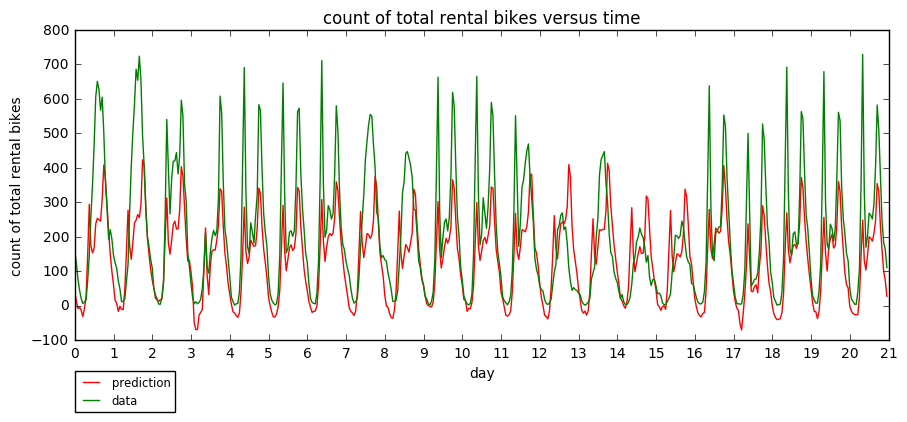

In [267]:
fig, ax = plt.subplots() 
fig.set_size_inches(10.5, 4)
plt.plot(last21Days_range, last21Days_predicts.astype('int64'), 'r', label="prediction")
plt.plot(last21Days_range, last21Days_labels.astype('int64'), 'g', label="data")
ax.set_xlim(right=num)
ax.set_xticks(np.arange(0, num+24, 24))
ax.set_xticklabels(np.arange(0, 22, 1))
plt.xlabel('day')
plt.ylabel('count of total rental bikes')
plt.title("count of total rental bikes versus time")
plt.legend(bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0., fontsize='small')
plt.show()
plt.close()

In [268]:
InteractiveShell.ast_node_interactivity = "all"

# 应用算法到测试集